**Importok**

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Konfiguracio + mappák**

In [3]:
DATASET_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "val")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 6
EPOCHS_FINE = 6
SEED = 42

OUT_ROOT = "/kaggle/working"
FIG_DIR = os.path.join(OUT_ROOT, "figures")
MET_DIR = os.path.join(OUT_ROOT, "metrics")
MODEL_DIR = os.path.join(OUT_ROOT, "models")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MET_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

**Adatgenerátorok**

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.6,
    height_shift_range = 0.6,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)

print("Class indices:", train_gen.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


**Class weight**

In [7]:
counts = np.bincount(train_gen.classes)
total = counts.sum()
class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
print("Train class counts:", counts, "class_weight:", class_weight)

Train class counts: [1341 3875] class_weight: {0: 1.9448173005219984, 1: 0.6730322580645162}


**Modell**

In [9]:
base = MobileNetV2(
    weights = "imagenet",
    include_top = False,
    input_tensor = Input(shape=(224, 224, 3))
)

#fagyasztas
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.5)(x)
out = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = base.inputs, outputs = out)

model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

/tmp/ipykernel_47/1719671025.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(
I0000 00:00:1767112346.330887      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Callbackek + checkpoint**

In [12]:
ckpt_path = os.path.join(MODEL_DIR, "mobilenetv2_best.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-7),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

**Tanítás - head**

In [13]:
history1 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_INITIAL,
    callbacks = callbacks,
    class_weight = class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1767112523.264616    1493 service.cc:148] XLA service 0x78241c003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767112523.265538    1493 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767112524.209300    1493 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 27:41 10s/step - accuracy: 0.7500 - loss: 0.6174

I0000 00:00:1767112528.036104    1493 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 831ms/step - accuracy: 0.7693 - loss: 0.4633 - val_accuracy: 0.9375 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.8925 - loss: 0.2499 - val_accuracy: 0.8750 - val_loss: 0.2491 - learning_rate: 1.0000e-04
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9082 - loss: 0.2318 - val_accuracy: 0.9375 - val_loss: 0.2163 - learning_rate: 1.0000e-04
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9031 - loss: 0.2262 - val_accuracy: 0.9375 - val_loss: 0.2144 - learning_rate: 1.0000e-04
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 563ms/step - accuracy: 0.9188 - loss: 0.2044 - val_accuracy: 0.8750 - val_loss: 0.2358 - learning_rate: 1.0000e-04
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.9278 - loss: 0.1842 - val_accuracy: 0.9375 - val_loss: 0.2108 - learning_rate: 1.0000e-04


**Fine-tune**

In [14]:
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_FINE,
    callbacks = callbacks,
    class_weight = class_weight
)

Epoch 1/6


E0000 00:00:1767113358.054970    1493 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767113358.252389    1493 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 600ms/step - accuracy: 0.8737 - loss: 0.2777 - val_accuracy: 0.7500 - val_loss: 0.2934 - learning_rate: 1.0000e-05
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - accuracy: 0.9112 - loss: 0.2137 - val_accuracy: 0.7500 - val_loss: 0.3518 - learning_rate: 1.0000e-05
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.9243 - loss: 0.1771 - val_accuracy: 0.8125 - val_loss: 0.3432 - learning_rate: 1.0000e-05
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.9292 - loss: 0.1740 - val_accuracy: 0.8750 - val_loss: 0.3808 - learning_rate: 1.0000e-05
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 563ms/step - accuracy: 0.9391 - loss: 0.1489 - val_accuracy: 0.8750 - val_loss: 0.3598 - learning_rate: 3.0000e-06
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9339 - loss: 0.1484 - val_accuracy: 0.8125 - val_loss: 0.3242 - learning_rate: 3.0000e-06


**Grafikonok**

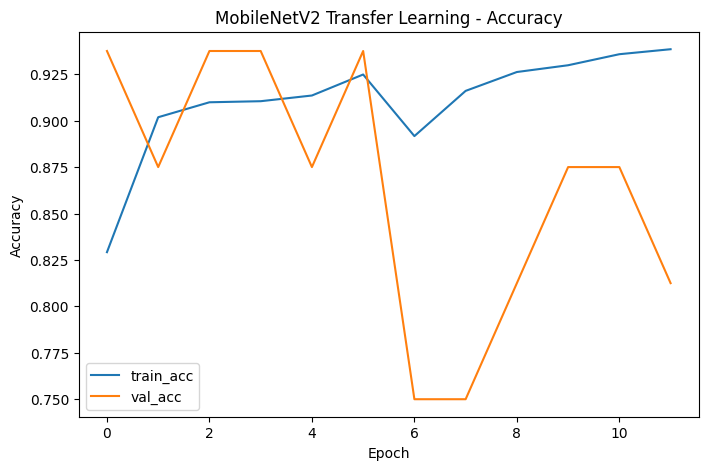

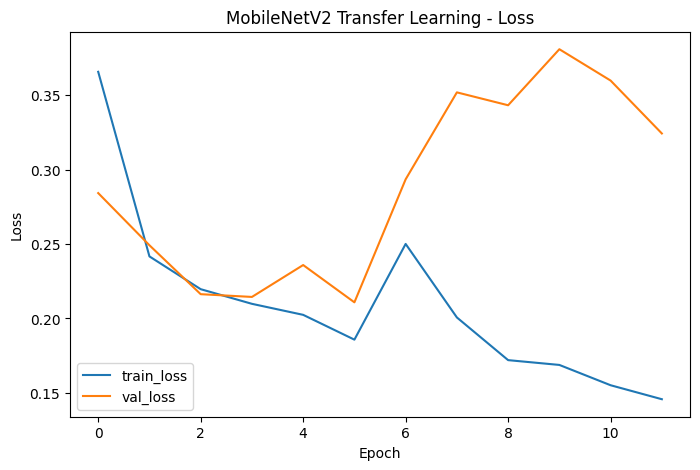

Saved: /kaggle/working/figures/mobilenetv2_accuracy.png
Saved: /kaggle/working/figures/mobilenetv2_loss.png


In [15]:
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history[k]
    return merged

hist = merge_histories(history1, history2)

plt.figure(figsize=(8,5))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNetV2 Transfer Learning - Accuracy")
plt.legend()
acc_path = os.path.join(FIG_DIR, "mobilenetv2_accuracy.png")
plt.savefig(acc_path, dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNetV2 Transfer Learning - Loss")
plt.legend()
loss_path = os.path.join(FIG_DIR, "mobilenetv2_loss.png")
plt.savefig(loss_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", acc_path)
print("Saved:", loss_path)

**Kiértékelés + mentés JSON**

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


              precision    recall  f1-score   support

      NORMAL       0.86      0.89      0.87       234
   PNEUMONIA       0.93      0.91      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624



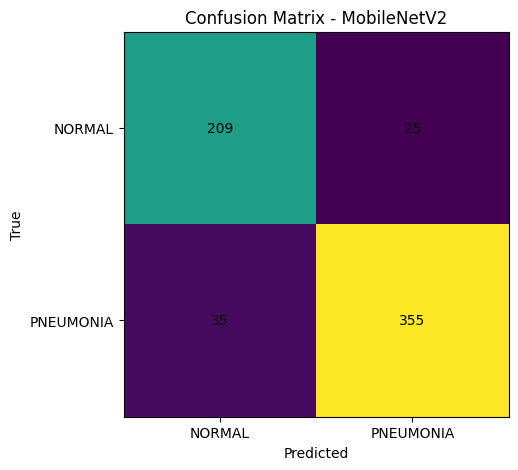

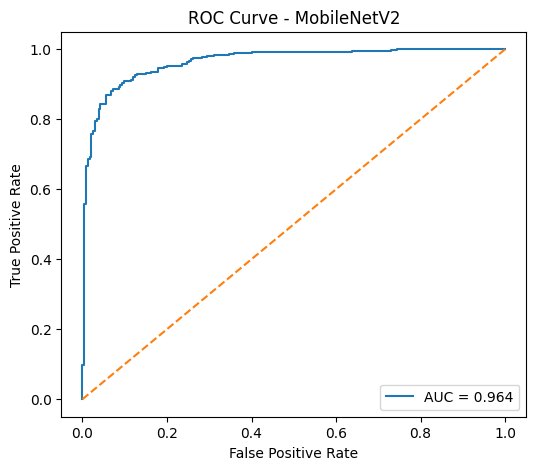

Saved: /kaggle/working/figures/mobilenetv2_confusion_matrix.png
Saved: /kaggle/working/figures/mobilenetv2_roc.png
Saved: /kaggle/working/metrics/mobilenetv2_metrics.json


In [16]:
model.load_weights(ckpt_path)

test_gen.reset()
y_prob = model.predict(test_gen, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

report = classification_report(
    y_true, y_pred,
    target_names=["NORMAL", "PNEUMONIA"],
    output_dict=True
)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
plt.imshow(cm)
plt.title("Confusion Matrix - MobileNetV2")
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.yticks([0,1], ["NORMAL", "PNEUMONIA"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
cm_path = os.path.join(FIG_DIR, "mobilenetv2_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MobileNetV2")
plt.legend()
roc_path = os.path.join(FIG_DIR, "mobilenetv2_roc.png")
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

metrics_out = {
    "model": "MobileNetV2_transfer",
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs_total": len(hist["loss"]),
    "roc_auc": float(roc_auc),
    "confusion_matrix": cm.tolist(),
    "classification_report": report
}

met_path = os.path.join(MET_DIR, "mobilenetv2_metrics.json")
with open(met_path, "w") as f:
    json.dump(metrics_out, f, indent=2)

print("Saved:", cm_path)
print("Saved:", roc_path)
print("Saved:", met_path)

**Modell save**

In [17]:
final_model_path = os.path.join(MODEL_DIR, "mobilenetv2_final.keras")
model.save(final_model_path)
print("Saved:", final_model_path)

Saved: /kaggle/working/models/mobilenetv2_final.keras


**Random predikciok**

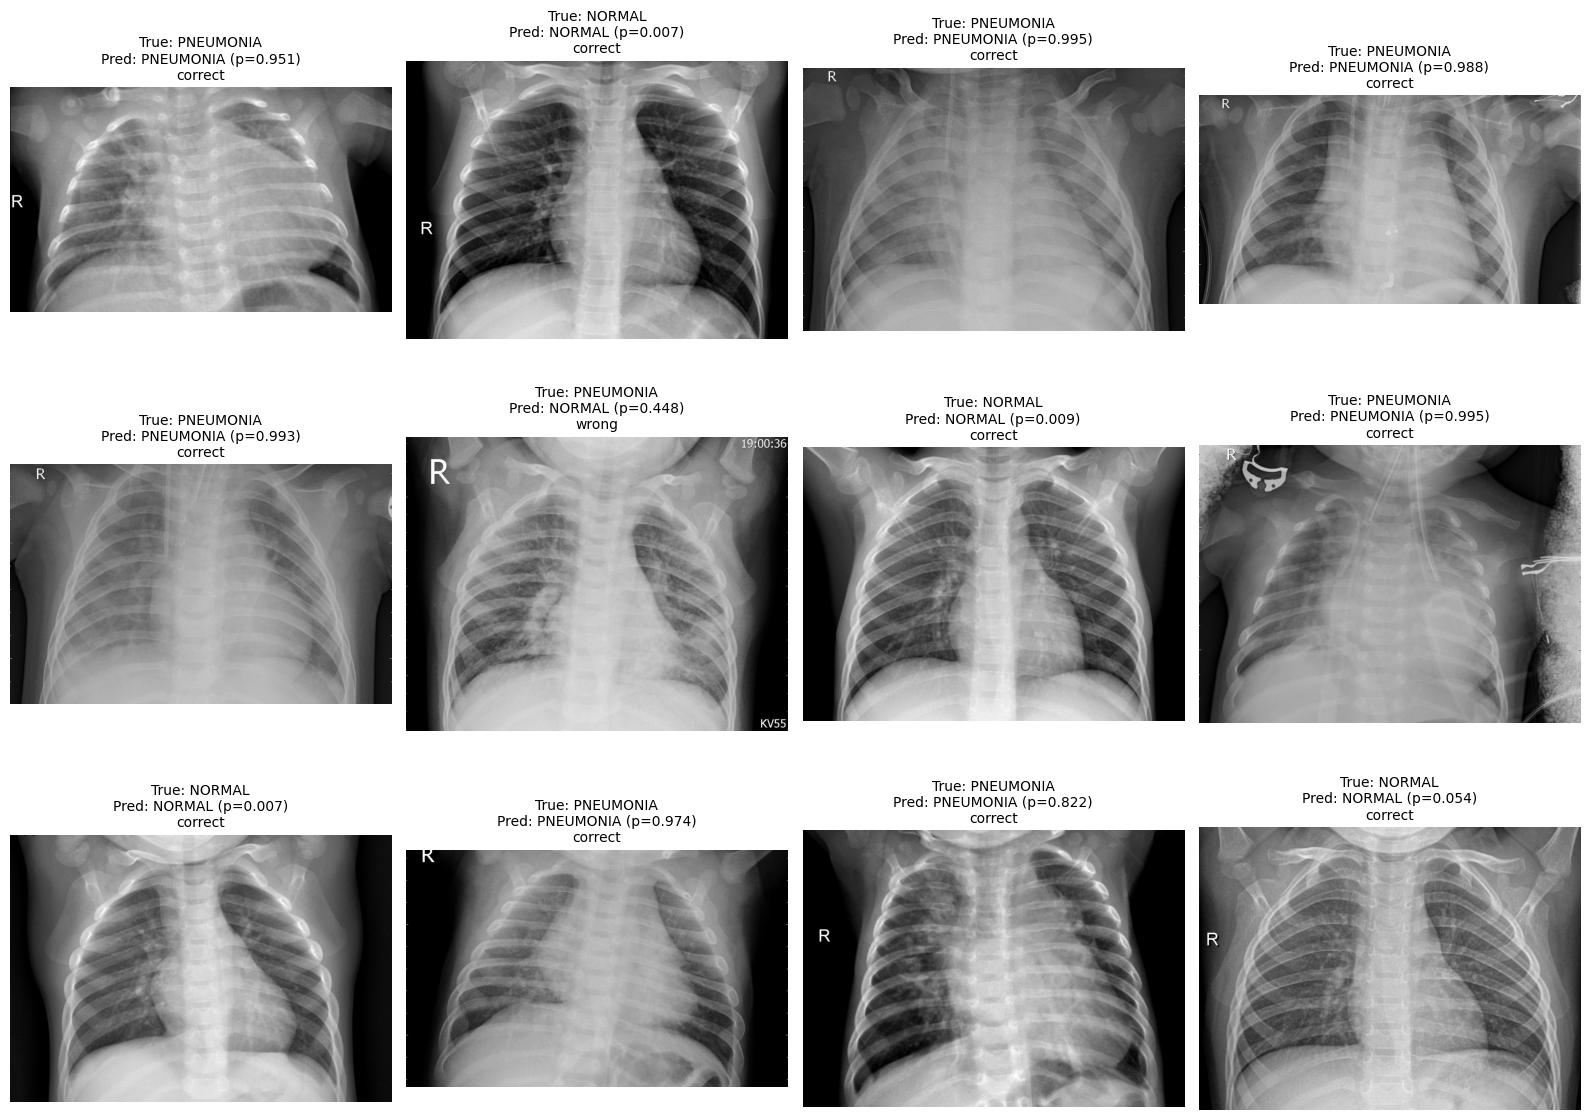

In [24]:
def show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42):
    """
    Random minták a teszt halmazból: kép + true/pred + prob + helyes/hibás jelzés.
    Feltételezi, hogy test_gen shuffle=False.
    """
    rng = np.random.default_rng(seed)

    #predikcio a teljes teszthalmazra(egyszer)
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    #indexek kivalasztasa
    idxs = rng.choice(len(y_true), size=min(n, len(y_true)), replace=False)

    #osztalynevek
    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}  # pl. {0:"NORMAL",1:"PNEUMONIA"}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(idxs) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(idxs, start=1):
        #kep betoltese fajlbol
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        correct = (true_label == pred_label)
        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"{'correct' if correct else 'wrong'}"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42)

**Top hibák**

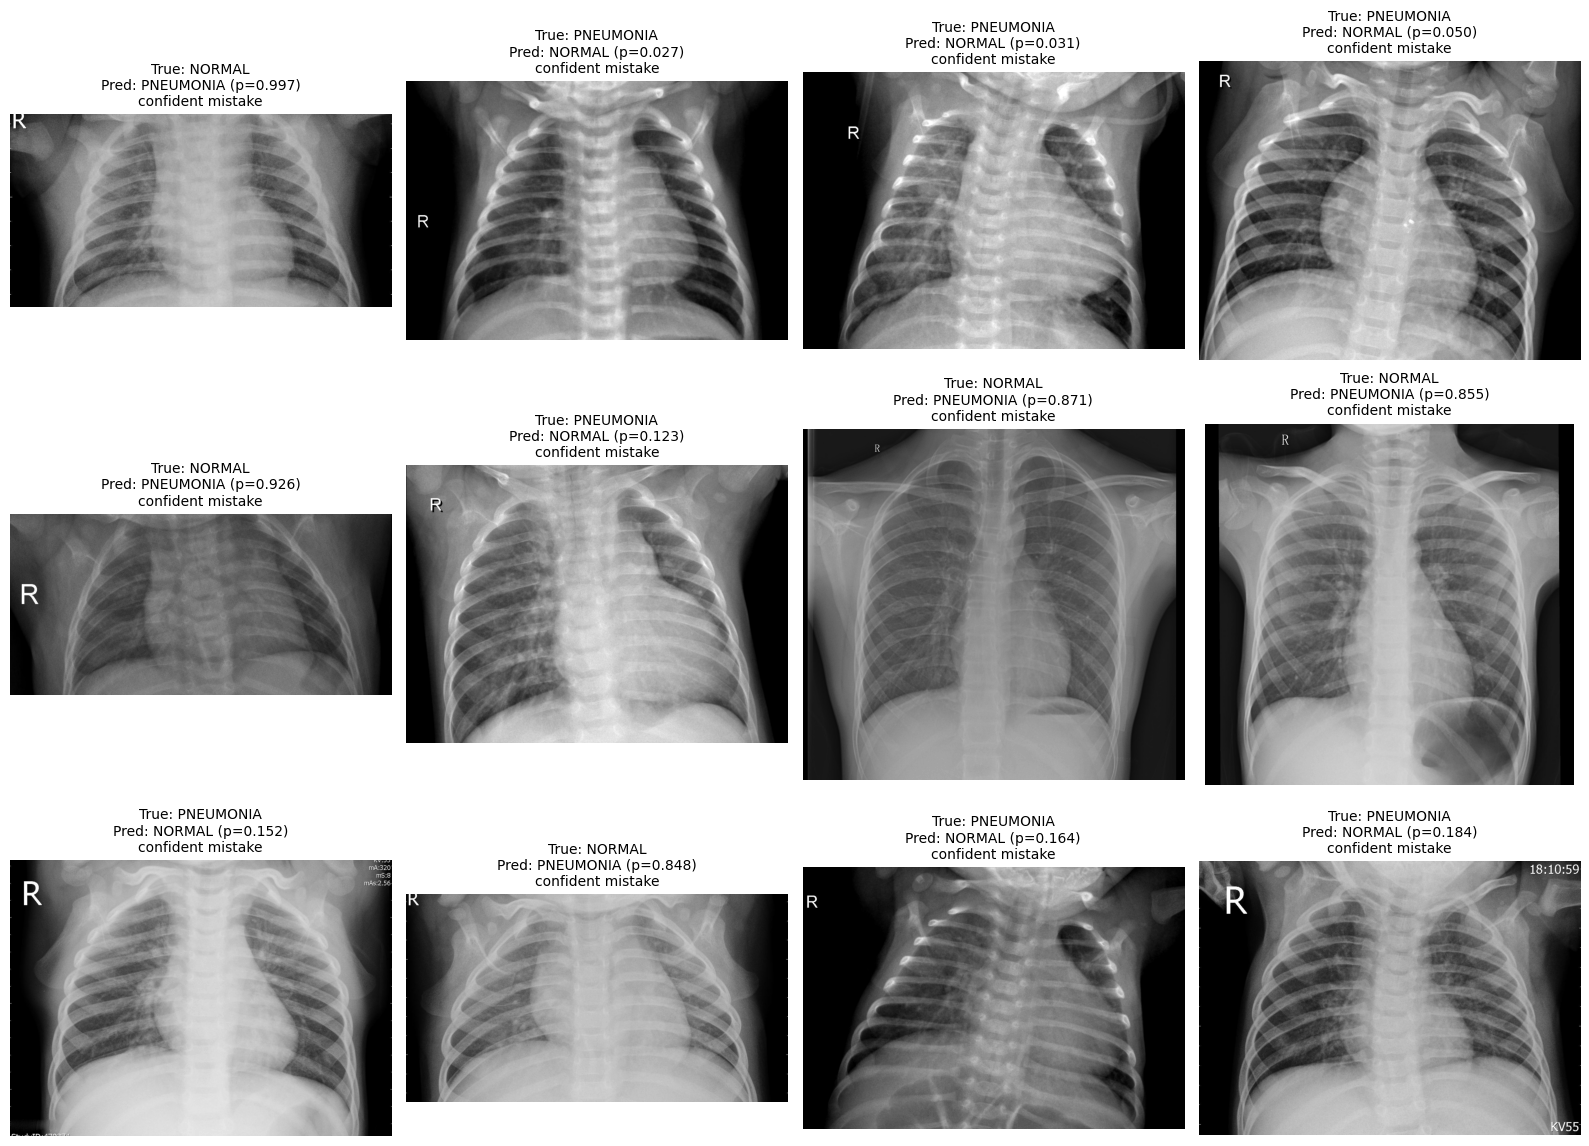

In [26]:
def show_top_mistakes(model, test_gen, k=12, threshold=0.5):
    """
    Megmutatja a k legmagabiztosabb tévedést a teszthalmazból.
    """
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("Nincs tévesztés a teszthalmazon ezzel a threshold-dal.")
        return

    #"magabiztossag" = mennyire tavol van a 0.5-tol
    confidence = np.abs(y_prob[wrong] - threshold)
    top_wrong = wrong[np.argsort(-confidence)][:min(k, len(wrong))]

    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(top_wrong) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(top_wrong, start=1):
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"confident mistake"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

show_top_mistakes(model, test_gen, k=12, threshold=0.5)

**Grad-CAM**

In [27]:
def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nem talalhato Conv2D reteg, Grad-CAM nem alkalmazhato")

last_conv_name = find_last_conv_layer_name(model)
print("Last conv layer:", last_conv_name)

Last conv layer: Conv_1


In [28]:
def make_gradcam_heatmap(img_batch, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch, training=False)
        score = preds[:, 0]  # sigmoid output

    grads = tape.gradient(score, conv_out)           # (1, Hc, Wc, C)
    pooled_grads = tf.reduce_mean(grads, axis=(1,2)) # (1, C)

    conv_out = conv_out[0]         # (Hc, Wc, C)
    pooled_grads = pooled_grads[0] # (C,)

    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1) # (Hc, Wc)
    heatmap = tf.maximum(heatmap, 0)

    heatmap /= (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


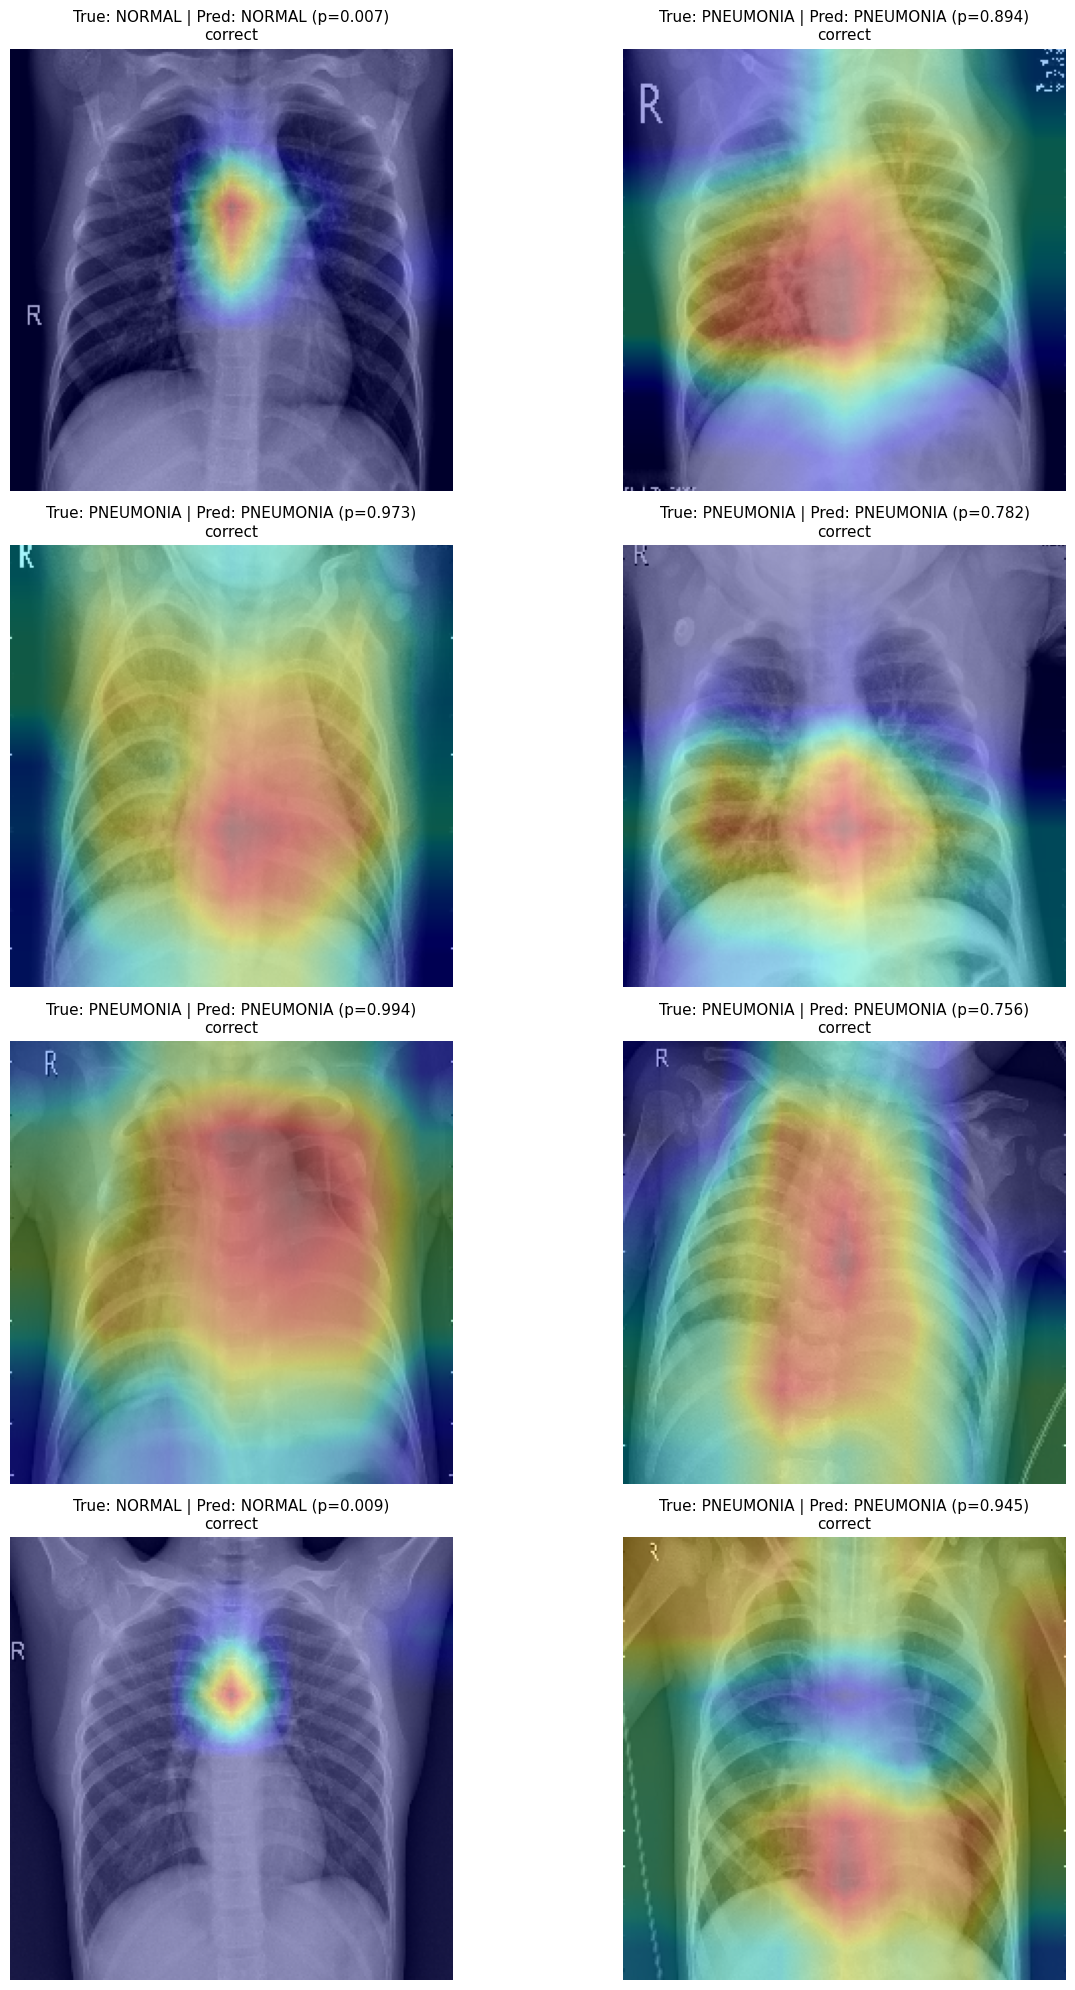

Saved Grad-CAM overlays to: /kaggle/working/figures/gradcam_mobilenetv2


In [29]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def overlay_heatmap(img_rgb_01, heatmap, alpha=0.35):
    heatmap_tf = tf.convert_to_tensor(heatmap[..., np.newaxis], dtype=tf.float32)
    heatmap_tf = tf.image.resize(heatmap_tf, (img_rgb_01.shape[0], img_rgb_01.shape[1]))
    heatmap_resized = heatmap_tf.numpy().squeeze()

    cmap = plt.get_cmap("jet")
    colored = cmap(heatmap_resized)[:, :, :3]

    overlay = (1 - alpha) * img_rgb_01 + alpha * colored
    return np.clip(overlay, 0, 1)

def gradcam_on_test_samples_efficientnet(model, test_gen, last_conv_layer_name,
                                         n=8, threshold=0.5, seed=42,
                                         save_dir="/kaggle/working/figures/gradcam_mobilenetv2"):
    rng = np.random.default_rng(seed)

    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [idx_to_class[0], idx_to_class[1]]

    idxs = rng.choice(len(y_true), size=min(n, len(y_true)), replace=False)

    os.makedirs(save_dir, exist_ok=True)

    cols = 2
    rows = int(np.ceil(len(idxs) / cols))
    plt.figure(figsize=(cols * 7, rows * 5))

    for i, idx in enumerate(idxs, start=1):
        img_path = test_gen.filepaths[idx]

        pil_img = tf.keras.utils.load_img(img_path, target_size=test_gen.target_size)
        img_arr = tf.keras.utils.img_to_array(pil_img)  # 0..255 float

        img_rgb_01 = img_arr / 255.0

        img_for_model = preprocess_input(img_arr.copy())
        img_batch = np.expand_dims(img_for_model, axis=0)

        heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)
        overlay_img = overlay_heatmap(img_rgb_01, heatmap, alpha=0.35)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]
        correct = (true_label == pred_label)

        title = (
            f"True: {class_names[true_label]} | Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"{'correct' if correct else 'wrong'}"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(overlay_img)
        plt.axis("off")
        plt.title(title, fontsize=11)

        out_name = f"gradcam_{i:02d}_idx{idx}_true{class_names[true_label]}_pred{class_names[pred_label]}_p{prob:.3f}.png"
        plt.imsave(os.path.join(save_dir, out_name), overlay_img)

    plt.tight_layout()
    plt.show()
    print("Saved Grad-CAM overlays to:", save_dir)

gradcam_on_test_samples_efficientnet(
    model=model,
    test_gen=test_gen,
    last_conv_layer_name=last_conv_name,
    n=8,
    threshold=0.5,
    seed=42
)